In [24]:
import pandas as pd

bank_df = pd.read_csv('bank.csv') # csv has ; as delimiter
bank_df = pd.read_csv('bank.csv', sep=';')  # Specify the correct delimiter
bank_df.columns = [col.strip() for col in bank_df.columns]  # Remove leading/trailing whitespace from column names
bank_df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [25]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   age         4521 non-null   int64 
 1   job         4521 non-null   object
 2   marital     4521 non-null   object
 3   education   4521 non-null   object
 4   default     4521 non-null   object
 5   balance     4521 non-null   int64 
 6   housing     4521 non-null   object
 7   loan        4521 non-null   object
 8   contact     4521 non-null   object
 9   day         4521 non-null   int64 
 10  month       4521 non-null   object
 11  duration    4521 non-null   int64 
 12  campaign    4521 non-null   int64 
 13  pdays       4521 non-null   int64 
 14  previous    4521 non-null   int64 
 15  poutcome    4521 non-null   object
 16  subscribed  4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [26]:
bank_df.subscribed.value_counts()

subscribed
no     4000
yes     521
Name: count, dtype: int64

In [27]:
## Importing resample from *sklearn.utils* package.
from sklearn.utils import resample

# Separate the case of yes-subscribes and no-subscribes
bank_subscribed_no = bank_df[bank_df.subscribed == 'no']
bank_subscribed_yes = bank_df[bank_df.subscribed == 'yes']

##Upsample the yes-subscribed cases.
df_minority_upsampled = resample(bank_subscribed_yes, 
                                 replace=True,     # sample with replacement
                                 n_samples=2000) 

# Combine majority class with upsampled minority class
new_bank_df = pd.concat([bank_subscribed_no, df_minority_upsampled])

In [32]:
from sklearn.utils import shuffle
new_bank_df = shuffle(new_bank_df)

new_bank_df.subscribed.value_counts()

subscribed
no     4000
yes    2000
Name: count, dtype: int64

In [33]:
# Assigning list of all column names in the DataFrame
X_features = list( new_bank_df.columns )
# Remove the response variable from the list
X_features.remove( 'subscribed' )
X_features

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome']

In [34]:
## get_dummies() will convert all the columns with data type as objects
encoded_bank_df = pd.get_dummies( new_bank_df[X_features], drop_first = True )
X = encoded_bank_df

In [35]:
# Encoding the subscribed column and assigning to Y
Y = new_bank_df.subscribed.map( lambda x: int( x == 'yes') )

In [36]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split( X,
                                                    Y,
                                                    test_size = 0.3,
                                                    random_state = 42 )

In [37]:
## Importing the KNN classifier algorithm
from sklearn.neighbors import KNeighborsClassifier

## Initializing the classifier
knn_clf = KNeighborsClassifier()
## Fitting the model with the training set
knn_clf.fit( train_X, train_y )

KNeighborsClassifier()

In [38]:
## Predicting on test set
pred_y = knn_clf.predict(test_X)

In [41]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn

def draw_cm(actual, predicted):
    # Compute the confusion matrix with labels specified explicitly
    cm = metrics.confusion_matrix(actual, predicted, labels=[1, 0])
    
    # Plot the confusion matrix as a heatmap
    sn.heatmap(cm, annot=True, fmt='.2f',
               xticklabels=["Subscribed", "Not Subscribed"],
               yticklabels=["Subscribed", "Not Subscribed"])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

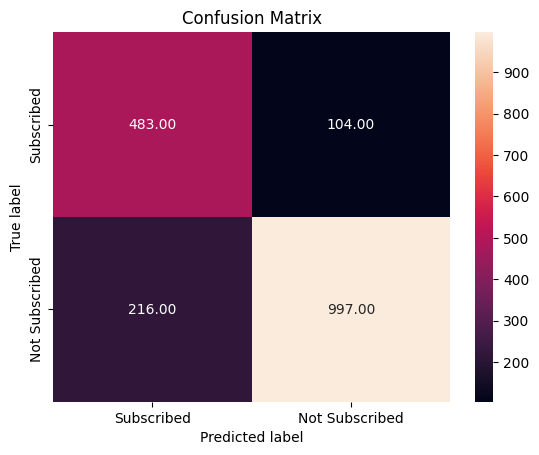

In [42]:
## Drawing the confusion matrix for KNN model 
draw_cm( test_y, pred_y )

In [43]:
print( metrics.classification_report( test_y, pred_y ) )

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1213
           1       0.69      0.82      0.75       587

    accuracy                           0.82      1800
   macro avg       0.80      0.82      0.81      1800
weighted avg       0.84      0.82      0.83      1800



In [44]:
## The method takes the three following parameters
## model: the classification model
## test_X: X features of the test set
## test_y: actual labels of the test set
## Returns
##  - ROC Auc Score
##  - FPR and TPRs for different threshold values
def draw_roc_curve( model, test_X, test_y ):
    ## Creating and initializing a results DataFrame with actual labels
    test_results_df = pd.DataFrame( { 'actual':  test_y } )
    test_results_df = test_results_df.reset_index()

    # predict the probabilities on the test set
    predict_proba_df = pd.DataFrame( model.predict_proba( test_X ) )

    ## selecting the probabilities that the test example belongs to class 1
    test_results_df['chd_1'] = predict_proba_df.iloc[:,1:2]
    
    
    ## Invoke roc_curve() to return the fpr, tpr and threshold values.
    ## threshold values contain values from 0.0 to 1.0 
    fpr, tpr, thresholds = metrics.roc_curve( test_results_df.actual,
                                           test_results_df.chd_1,
                                           drop_intermediate = False )

    ## Getting the roc auc score by invoking metrics.roc_auc_score method
    auc_score = metrics.roc_auc_score( test_results_df.actual, test_results_df.chd_1  )

    ## Setting the size of the plot
    plt.figure(figsize=(8, 6))
    ## plotting the actual fpr and tpr values 
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    ## plotting th diagnoal line from (0,1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    ## Setting labels and titles
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    return auc_score, fpr, tpr, thresholds

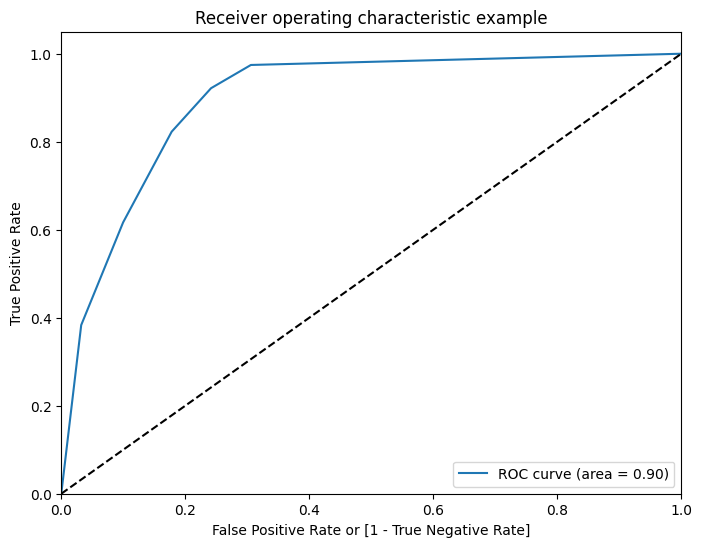

In [45]:
from sklearn.metrics import roc_auc_score

## Invoking draw_roc_curve with the KNN model
draw_roc_curve(knn_clf, test_X, test_y);

In [46]:
## Importing GridSearchCV
from sklearn.model_selection import GridSearchCV

## Creating a dictionary with hyperparameters and possible values for searching
tuned_parameters = [{'n_neighbors': range(5,10), 
                     'metric': ['canberra', 'euclidean', 'minkowski']}]

## Configuring grid search
clf = GridSearchCV(KNeighborsClassifier(),
                 tuned_parameters,
                 cv=10,
                 scoring='roc_auc')
## fit the search with training set
clf.fit(train_X, train_y )

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid=[{'metric': ['canberra', 'euclidean', 'minkowski'],
                          'n_neighbors': range(5, 10)}],
             scoring='roc_auc')

In [47]:
clf.best_score_

np.float64(0.8971969148124422)

In [48]:
clf.best_params_

{'metric': 'canberra', 'n_neighbors': 5}

In [49]:
## Importing Random Forest Classifier from the sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier

## Initializing the Random Forest Classifier with max_dept and n_estimators
radm_clf = RandomForestClassifier( max_depth=10, n_estimators=10)
radm_clf.fit( train_X, train_y )

RandomForestClassifier(max_depth=10, n_estimators=10)

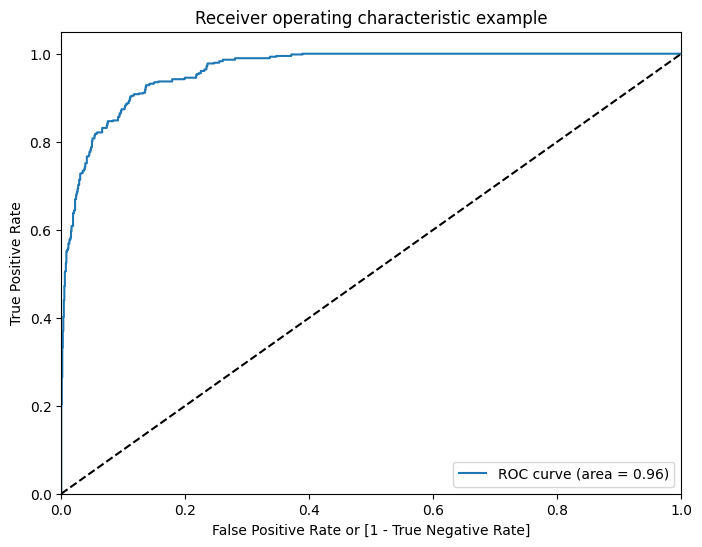

In [50]:
_, _, _, _ = draw_roc_curve( radm_clf, test_X, test_y );

In [51]:
clf.best_score_

np.float64(0.8971969148124422)

In [52]:
clf.best_params_

{'metric': 'canberra', 'n_neighbors': 5}